In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as st

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Load data

In [2]:
lyrics_path = "data/lyrics-data.csv"
lyrics_pd_df = pd.read_csv(lyrics_path)

artists_path = "data/artists-data.csv"
artists_pd_df = pd.read_csv(artists_path)

## First quick and dirty look at data in pandas

In [3]:
def df_overview(df: pd.DataFrame, number_of_lines: int = 10):
    
    print("Info about df:")
    print(df.info())
    
    print("\n")
    print("#" * 60)
    print("\n")
    
    print("Shape of df:")
    print(df.shape)
    
    print("\n")
    print("#" * 60)
    print("\n")
    
    print(f"First {number_of_lines} of df:")
    print(df.head(number_of_lines))
    
    print("\n")
    print("#" * 60)
    print("\n")

In [4]:
lyrics_pd_df.language.unique()

array(['pt', 'es', 'en', nan, 'it', 'gl', 'fr', 'de', 'tl', 'et', 'fi',
       'pl', 'da', 'st', 'sv', 'ro', 'af', 'no', 'eu', 'rw', 'sw', 'ga',
       'cy', 'ca', 'ny', 'ko', 'ar', 'gd', 'tr', 'id', 'su', 'lg', 'ru',
       'nl', 'sq', 'is', 'cs', 'jw', 'lv', 'hu', 'ms', 'ku', 'zh', 'hr',
       'ht', 'fa', 'mg', 'vi', 'ja', 'hmn', 'sr', 'iw', 'sl'],
      dtype=object)

In [5]:
lyrics_en_pd_df = lyrics_pd_df[lyrics_pd_df["language"] == "en"]

In [6]:
df_overview(lyrics_en_pd_df)

Info about df:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191814 entries, 69 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     191814 non-null  object
 1   SName     191812 non-null  object
 2   SLink     191814 non-null  object
 3   Lyric     191814 non-null  object
 4   language  191814 non-null  object
dtypes: object(5)
memory usage: 8.8+ MB
None


############################################################


Shape of df:
(191814, 5)


############################################################


First 10 of df:
               ALink                                              SName  \
69   /ivete-sangalo/                                   Careless Whisper   
86   /ivete-sangalo/  Could You Be Loved / Citação Musical do Rap: S...   
88   /ivete-sangalo/                             Cruisin' (Part. Saulo)   
111  /ivete-sangalo/                                               Easy   
140  /ivet

In [7]:
df_overview(artists_pd_df)

Info about df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB
None


############################################################


Shape of df:
(4168, 5)


############################################################


First 10 of df:
                Artist                  Genres  Songs  Popularity  \
0        Ivete Sangalo     Pop; Axé; Romântico  313.0         4.4   
1  Chiclete com Banana                     Axé  268.0         3.8   
2            Banda Eva  Axé; Romântico; Reggae  215.0         2.3   
3            É O Tchan                     Axé  129.0         1.6   
4       Claudia Lei

In [8]:
# Merge artists and lyrics
songs_pd_df = pd.merge(
    lyrics_en_pd_df, 
    artists_pd_df, 
    how="inner",
    left_on="ALink",
    right_on="Link"
)
# Remove duplicate collumn
del songs_pd_df["Link"]

songs_pd_df.head()

,ALink,SName,SLink,Lyric,language,Artist,Genres,Songs,Popularity
0,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4
2,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4
3,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4
4,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4


In [9]:
number_of_artists = songs_pd_df.Artist.nunique()
print(f"Number of unique artists: {number_of_artists}")

# use SLink, since song name could appear twice
# but is more unique with artist name
number_of_songs = songs_pd_df.SLink.nunique()
print(f"Number of unique songs: {number_of_songs}")

Number of unique artists: 2488
Number of unique songs: 191366


### Weird Artist names
Interestingly Artists can also be titles of movies

In [23]:
songs_pd_df.groupby("Artist").mean()

/var/folders/47/kf2nw7g97xj4bnnf6pdqwq640000gp/T/ipykernel_65916/300481635.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  songs_pd_df.groupby("Artist").mean()


,Songs,Popularity
Artist,,
*NSYNC,116.0,1.5
+44,15.0,0.0
10 Things I Hate About You,18.0,0.0
10000 Maniacs,110.0,0.0
10cc,141.0,0.0
...,...,...
f(x),81.0,0.0
one:day:life,12.0,0.0
t.A.T.u.,83.0,3.0


In [24]:
songs_pd_df[songs_pd_df["Artist"] == "10 Things I Hate About You"].head()

,ALink,SName,SLink,Lyric,language,Artist,Genres,Songs,Popularity
190270,/10-things-i-hate-about-you/,"I Love You, Baby",/10-things-i-hate-about-you/i-love-you-baby.html,"You're just too good to be true,\nCan't take m...",en,10 Things I Hate About You,Trilha Sonora; Rock Alternativo; Romântico,18.0,0.0
190271,/10-things-i-hate-about-you/,The Poem,/10-things-i-hate-about-you/the-poem.html,I hate the way you talk to me\nAnd the way you...,en,10 Things I Hate About You,Trilha Sonora; Rock Alternativo; Romântico,18.0,0.0
190272,/10-things-i-hate-about-you/,Atomic Dog,/10-things-i-hate-about-you/atomic-dog.html,"Yeah, this is a story of a famous dog\nFor the...",en,10 Things I Hate About You,Trilha Sonora; Rock Alternativo; Romântico,18.0,0.0
190273,/10-things-i-hate-about-you/,Calypso-spiderbait,/10-things-i-hate-about-you/calypso-spiderbait...,"Sunshine,\nOn the window,\nMakes me happy,\nLi...",en,10 Things I Hate About You,Trilha Sonora; Rock Alternativo; Romântico,18.0,0.0
190274,/10-things-i-hate-about-you/,Even Angels Fall,/10-things-i-hate-about-you/even-angels-fall.html,"You've found hope\nYou've found faith,\nFound ...",en,10 Things I Hate About You,Trilha Sonora; Rock Alternativo; Romântico,18.0,0.0


### Closer look at Artists

In [14]:
songs_pd_df.groupby("Artist").first().Songs.sort_values(ascending=False)

Artist
Frank Sinatra           828.0
Matheus Hardke          797.0
Elvis Presley           759.0
Dolly Parton            723.0
Hillsong United         695.0
                        ...  
Uma Banda Lá em Casa      1.0
Rocky Burnette            1.0
Rylo Rodriguez            1.0
Banda Morfina             1.0
The Sopranos              1.0
Name: Songs, Length: 2488, dtype: float64

Freedman–Diaconis number of bins: 58


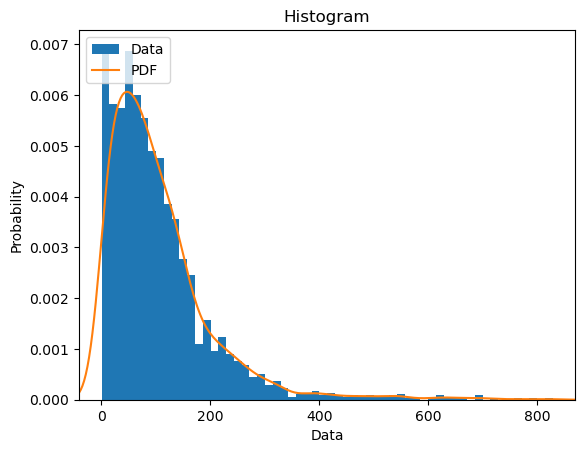

In [41]:
y = songs_pd_df.groupby("Artist").first().Songs.index.values
x = songs_pd_df.groupby("Artist").first().Songs.values
N = len(labels)

colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

plt.hist(x, density=True, bins=bins, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Song counts")
plt.title("Histogram");